<a href="https://colab.research.google.com/github/eckoecho/CodingDojo/blob/week-7/Decision_Thresholds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, \
ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline

In [39]:
#Loading Data From Webpage
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTRfoQAojPwNsw33zUSpBg32DuK2z0WvLPptGOncIXa38tN3RWk9puvelcmsIIhFb_XF12RD7PdqCwf/pub?output=csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [41]:
#State X and y
X = df.drop(columns="HeartDisease", axis=1)
y = df["HeartDisease"]
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
#Finding percentage of HeartDisease's Value Count
y_train.value_counts(normalize="true")

1    0.553779
0    0.446221
Name: HeartDisease, dtype: float64

# Preprocessor object

In [42]:
# Create preprocessor to scale and one-hot encode the data
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
scaler = StandardScaler()
#Separate Data Types
cat_cols = make_column_selector(dtype_include='object')
num_cols = make_column_selector(dtype_include='number')
#Create tuple for ColumnnTransformer
cat_tuple = (ohe, cat_cols)
num_tuple = (scaler, num_cols)
#Instantiate ColumnTransformer
preprocessor = make_column_transformer(cat_tuple, num_tuple, remainder='drop')

# Fit and Evaluate a Model at Default Decision Threshold

In [43]:
# Create a model pipeline with the preprocessor and a KNN model
log_reg = LogisticRegression()
log_pipe = make_pipeline(preprocessor, log_reg)
log_pipe.fit(X_train, y_train)
test_preds = log_pipe.predict(X_test)
test_preds[:5]

array([1, 0, 1, 1, 1])

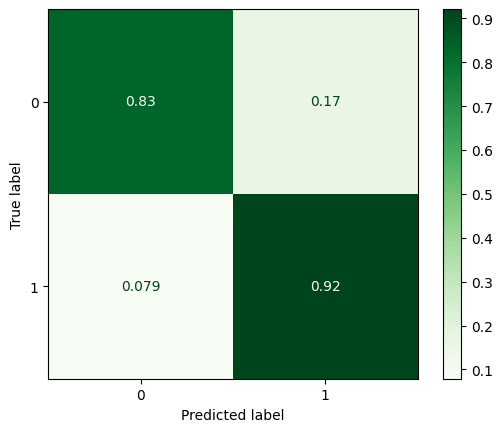

In [44]:
ConfusionMatrixDisplay.from_predictions(y_test, test_preds, normalize="true", cmap="Greens");

What if we want to **reduce** that **false negative** rate and are willing to accept a **higher false positive** rate? 

In [45]:
# Get the model probability predictions for the test set
test_probs = log_pipe.predict_proba(X_test)
test_probs[:5]

array([[0.17612435, 0.82387565],
       [0.79969141, 0.20030859],
       [0.10250987, 0.89749013],
       [0.38820655, 0.61179345],
       [0.45406137, 0.54593863]])

# Change the Decision Threshold for Prediction

In [46]:
def convert_probs_to_preds(probabilities, threshold, pos_class=1):
    """Converts float value probabilities into int value predictions.
  If the probability of class 1 is greater than the threshold, the prediction is 1
  Otherwise the prediction is 0
  pos_class determines the index of the positive class in the array of probabilies"""
    predictions = [1 if prob[pos_class] > threshold else 0 for prob in probabilities]
    return predictions


# Setting NEW Threshold

In [47]:
test_preds = convert_probs_to_predict(test_probs, .2)
test_preds[:5]

[1, 1, 1, 1, 1]

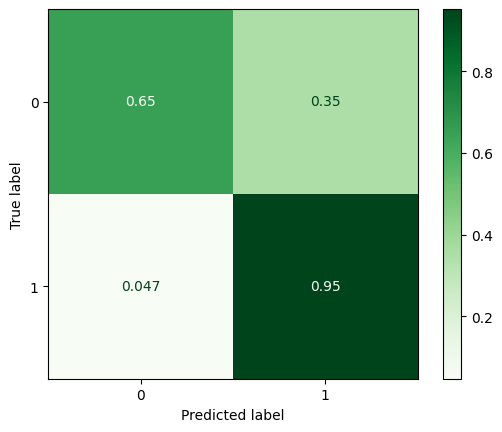

In [48]:
ConfusionMatrixDisplay.from_predictions(y_test, test_preds, normalize="true", cmap="Greens");

# Tuning the Decision Threshold

In [49]:
# Create an array of float values between 0 and 1 with a step size of .05
thresholds = np.arange(start=0, stop=1.05, step=.05)
# Create empty recall and precision lists
recalls = []
precisions = []
accuracies = []
# Iterate over thresholds
for thresh in thresholds:
  # Convert probabilities to predictions according to each threshold
  preds = convert_probs_to_preds(test_probs, thresh)
  # Record the recall and precision for predictions at that threshold
  recalls.append(recall_score(y_test, preds))
  precisions.append(precision_score(y_test, preds))
  accuracies.append(accuracy_score(y_test, preds))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


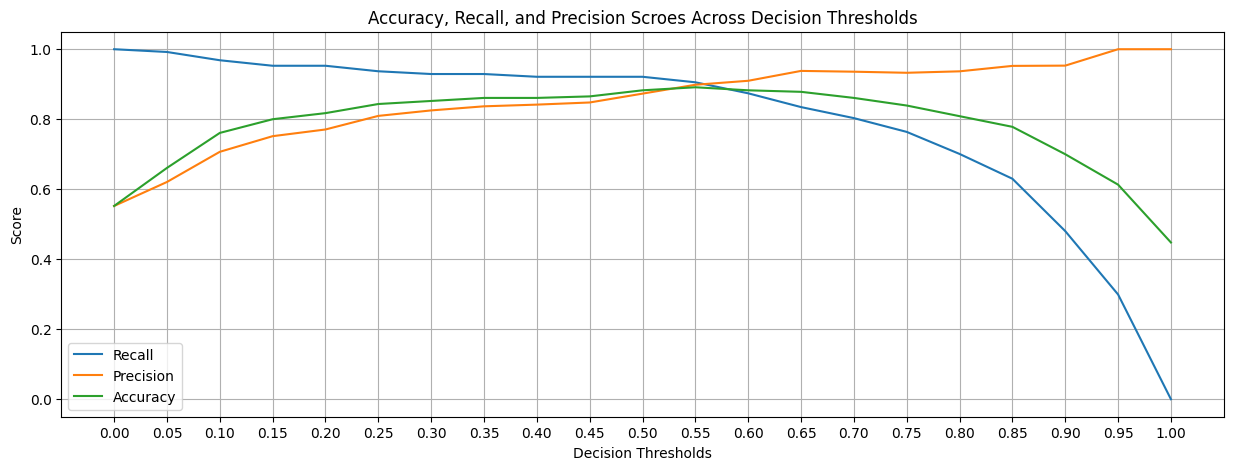

In [50]:
plt.figure(figsize=(15,5))
plt.plot(thresholds, recall, label="Recall")
plt.plot(thresholds, precision, label="Precision")
plt.plot(thresholds, accuracy, label="Accuracy")
plt.legend()
plt.title("Accuracy, Recall, and Precision Scroes Across Decision Thresholds")
plt.xlabel("Decision Thresholds")
plt.ylabel("Score")
plt.grid()
plt.xticks(thresholds)
plt.show()

# Changing Threshold

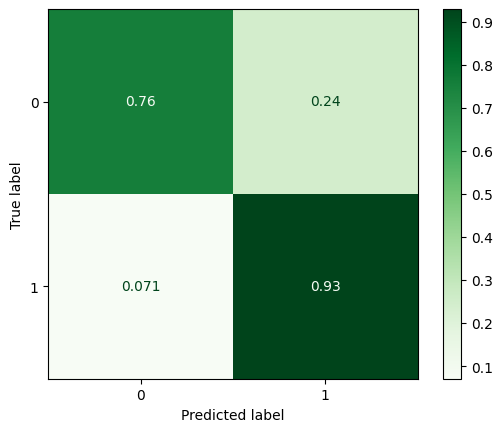

In [53]:
# Convert probabilites to class labels with a decision threshold of 0.3
test_preds = convert_probs_to_preds(test_probs, .3)
# Display a confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, test_preds, normalize="true", cmap="Greens");
plt.show()

In [54]:
# Print a classification report
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.90      0.76      0.82       103
           1       0.83      0.93      0.87       127

    accuracy                           0.85       230
   macro avg       0.86      0.84      0.85       230
weighted avg       0.86      0.85      0.85       230

